# CMPE 493 Assignment 3
### Initial Notes
* Written with python3, tested in MacOS Mojave 10.14.4
* All the requirements were seemed to be complete
* Sections with no expected time to complete are supposed to complete within 1 second.

In [1]:
import re
import os
import pickle
from collections import Counter
import math
import collections
import operator
import random
from rouge import Rouge
import numpy as np
import matplotlib.pyplot as plt

In [2]:
VECTOR_PATH = '../glove.6B.200d.pkl'
ARTICLES_PATH = '../articles/'
GOLD_SUMMARIES_PATH = '../gold_summaries/'

VECTOR_LENGTH = 200
DOC_NUMBER = 2225
FOLD_LENGTH = 200   # each fold consists of 200 documents, then 10 folds for the cross-validation process
                    # if number of training documents is 2000

* Takes ~10 Seconds

In [3]:
with open(VECTOR_PATH, 'rb') as f:
    vector = pickle.load(f)

In [4]:
# Remove punctuations from the text
def remove_punctuations(text):
    punctuations = ['"', '!', '^', '%', '<', '+', '~', '*', ';', ':', '(', '?', '&', '}', ']', '|', ',', "'", ')', '-', '#', '`', '@', '/', '$', '_', '{', '.', '>', '[', '\\', '=']
    for punctuation in punctuations:
        text = text.replace(punctuation, " ")
    return text

Parses documents to sentences by sentence tokenizing. 
Returns a list of lists that consists of the sentences and a dictionary that has the name of the document as key and list of the sentences for that document as array.
* lower: lower bound index of the documents that are going to be parsed 
* upper: upper bound index of the documents that are going to be parsed 

In [5]:
def parse_documents_to_sentences(lower=None, upper=None):
    docs_by_sentences = []
    docs_dict = dict()
    articles = []
    for (dirpath, dirnames, filenames) in os.walk(ARTICLES_PATH):
        articles.extend(filenames)
        break
    articles = sorted(sorted(articles), key=str.upper)
    if lower == None:
        lower = 0
    if upper == None:
        upper = len(articles)
    for article in articles[lower:upper]:
        docs_dict.setdefault(article, '')
        with open(ARTICLES_PATH + article, encoding="utf8", errors='ignore') as f:
            text = f.read().strip().lower()
            sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
            sentences = [remove_punctuations(sentence) for sentence in sentences]
            docs_by_sentences.append(sentences)
            docs_dict[article] = sentences
    return docs_by_sentences, docs_dict

Parses golden summaries to sentences by sentence tokenizing. 
Returns a list of lists that consists of the sentences and a dictionary that has the name of the document as key and list of the sentences for that document as array.
* lower: lower bound index of the documents that are going to be parsed 
* upper: upper bound index of the documents that are going to be parsed 

In [6]:
def read_golden_summaries(lower=None, upper=None):
    summaries = []
    summaries_dict = dict()
    summary_files = []
    for (dirpath, dirnames, filenames) in os.walk(GOLD_SUMMARIES_PATH):
        summary_files.extend(filenames)
        break
    summary_files = sorted(sorted(summary_files), key=str.upper)
    if lower == None:
        lower = 0
    if upper == None:
        upper = len(summary_files)
    for summary in summary_files[lower:upper]:
        summaries_dict.setdefault(summary, '')
        with open(GOLD_SUMMARIES_PATH + summary, encoding="utf8", errors='ignore') as f:
            text = f.read()
            summaries.append(text)
            summaries_dict[summary] = text
    return summaries, summaries_dict

## Sentence Representation

**sent2vec_by_averaging** forms sentence vector represantation of a sentence by simply taking the average of all its words' vectors if they are not stopwords


In [7]:
def sent2vec_by_averaging(docs_by_sentences, vector=vector): 
    docs_by_vectors = []
    stopwords = ['a', 'all', 'an', 'and', 'any', 'are', 'as', 'be', 'been', 'but', 'by ', 'few', 'for', 'have', 'he', 'her', 'here', 'him', 'his', 'how', 'i', 'in', 'is', 'it', 'its', 'many', 'me', 'my', 'none', 'of', 'on ', 'or', 'our', 'she', 'some', 'the', 'their', 'them', 'there', 'they', 'that ', 'this', 'us', 'was', 'what', 'when', 'where', 'which', 'who', 'why', 'will', 'with', 'you', 'your']

    #docs_by_vectors_dict = dict()
    
    for doc in docs_by_sentences:  #for each document
        sentences_by_vectors = []
        for sentence in doc:   #for each sentence in the document
            sentence_vector = [0 for i in range(VECTOR_LENGTH)]  # initialize the sentence representation vector
            sentence_length = 0
            for word in sentence.split():  # for each word in the sentence sum their vectors
                if word in vector.keys() and word not in stopwords:
                    sentence_vector = [x + y for x, y in zip(sentence_vector, vector[word])]
                    sentence_length += 1
            if sentence_length != 0:   # take the average 
                sentence_vector = [x / sentence_length for x in sentence_vector]
                sentences_by_vectors.append(sentence_vector)
        docs_by_vectors.append(sentences_by_vectors)
    
    return docs_by_vectors

## KMeans

There are 2 main kmeans methods two construct 2 models: fixed number of clusters method and elbow method.

In the fixed number of clusters method, cluster number is always set to 5, regardless of the lenght or content of the document.

In the elbow method for kmeans clustering, clustering wtih number of clusters of 5, 10 and 15 are done, within sums of squares are computed and the cluster with the least wss is chosen.

In [8]:
# finds the euclidian distace between 2 points
def get_euclidian_distance(vector1, vector2):
    if type(vector1) is not list or type(vector2) is not list:
        return 
    elif len(vector1) != len(vector2):
        raise ValueError('vector dimensions not equal')
    else:
        return math.sqrt(sum([(x  - y) ** 2 for x, y in zip(vector1, vector2)]))

In [9]:
# calculates the centroid of a list of points
def calculate_centroid(vector_list, number_of_dimensions=200):
    total_list = [0 for i in range(number_of_dimensions)]
    for i in range(len(vector_list)):
        total_list = [x + y for x, y in zip(total_list, vector_list[i])]
    if len(vector_list) != 0:
        total_list = [x / len(vector_list) for x in total_list]
        return total_list
    else:
        return -1

In [10]:
# given a list, returns the max and min values among its elements for all dimensions 
def get_max_min_lists(vector_list, number_of_dimensions=200):
    max_list = [-1 * math.inf for i in range(number_of_dimensions)]
    min_list = [math.inf for i in range(number_of_dimensions)]
    for i in range(len(vector_list)):
        max_list = [max(x, y) for x, y in zip(max_list, vector_list[i])]
        min_list = [min(x, y) for x, y in zip(min_list, vector_list[i])]
    return max_list, min_list

In [11]:
# returns the wss value of the given documents, centroids and assignments
def get_wss(docs_as_vectors, assignments, centroids):
    wss = 0
    for i in range(len(docs_as_vectors)):
        wss += get_euclidian_distance(docs_as_vectors[i], centroids[assignments[i]]) ** 2
    return wss      

In [12]:
# returns the closest point to the centroid among the given vectors
def get_closest_point(centroid, vectors):
    distance = math.inf
    closest = None
    for vector in vectors:
        if get_euclidian_distance(vector, centroid) < distance:
            distance = get_euclidian_distance(vector, centroid)
            closest = vector
    return closest

In [13]:
# clusters given list of vectors, returns assignment list and centroid list
def cluster(docs_as_vectors, number_of_dimensions=200, number_of_clusters=5):
    max_list, min_list = get_max_min_lists(docs_as_vectors)
    extracted_summaries = []
    centroids = [[0 for i in range(number_of_dimensions)] for j in range(number_of_clusters)]
    assignments = [-1 for i in range(len(docs_as_vectors))]
    for i in range(len(centroids)):
        for j in range(number_of_dimensions):
            centroids[i][j] = random.uniform(min_list[j], max_list[j])
    updated = True
    restart = False
    while updated:
        updated = False
        centroids = [centroid for centroid in centroids if type(centroid) is list]
        for vector in docs_as_vectors:
            distances = []
            for i in range(len(centroids)):
                distances.insert(i, get_euclidian_distance(vector, centroids[i]))
            if distances:
                assignment = distances.index(min(distances))
            if assignments[docs_as_vectors.index(vector)] != assignment:
                assignments[docs_as_vectors.index(vector)] = assignment
                updated = True
        for i in range(len(centroids)):
            members = [vector for vector in docs_as_vectors if assignments[docs_as_vectors.index(vector)] == i]
            centroids[i] = calculate_centroid(members)
    return assignments, centroids

In [14]:
# clusters with the elbow method by finding the minimal within sum of squares between the different cluster numbers
def cluster_with_wss(docs_as_vectors, number_of_dimensions=200):
    cluster5 = cluster(docs_as_vectors, number_of_dimensions=200, number_of_clusters=5)
    cluster10 = cluster(docs_as_vectors, number_of_dimensions=200, number_of_clusters=10)
    cluster15 = cluster(docs_as_vectors, number_of_dimensions=200, number_of_clusters=15)
    clusters = [cluster5, cluster10, cluster15]
    wss_values = [get_wss(docs_as_vectors, cluster[0], cluster[1]) for cluster in clusters]
    return clusters[wss_values.index(min(wss_values))]

## Model Selection
### Training and Cross Validation
Sentence representation is the simple averaging method of the words in the sentence if word is not a stopword.


The difference is in the clustering method. First model will be using kmeans clustering with fixed number of clusters where the number of clusters is set to 5. Second medel uses elbow method with within sums of squares method to find the optimal number of clusters: it clusters the given document with kmeans with number of clusters set to 5, 10 and 15 and calculates their respective wss values and uses the one with the least wss.

It does not require an actual training, though cross validation is still done with both models.

~3 seconds

In [15]:
train, train_dict = parse_documents_to_sentences(upper=2000)    # train set
test, test_dict = parse_documents_to_sentences(lower=2000)    # test set

summaries, summaries_dict = read_golden_summaries()

scores1 = [[] for i in range(int(len(train) / FOLD_LENGTH))]
scores2 = [[] for i in range(int(len(train) / FOLD_LENGTH))]
rouge = Rouge()

In [16]:
rouge1_1 = []   # model 1 rouge 1
rouge2_1 = []   # model 1 rouge 2
rougel_1 = []   # model 1 rouge l

rouge1_2 = []   # model 2 rouge 1
rouge2_2 = []   # model 2 rouge 2
rougel_2 = []   # model 2 rouge l

Both models are constructed in this section, inside the for loop, under the comments of models. Model 1 uses kmeans clustering with ficed number of clusters, second model uses clustering with elbow method.

Cross validation is also done in this section where training set is split to K folds and training is done with K-1 folds and scores are tested on the remaining kth fold, for each fold. However both of my models don't require an actual training, cross validation is directly done instead.

~5 minutes

In [17]:
for i in range(int(len(train) / FOLD_LENGTH)):
    validation = train[i * FOLD_LENGTH:(i + 1) * FOLD_LENGTH]
    dev = list(train)
    del dev[i * FOLD_LENGTH:(i + 1) * FOLD_LENGTH]
   
    docs_by_vectors1 = sent2vec_by_averaging(validation)

    ######### MODEL 1 - FIXED NUMBER OF CLUSTERS ###########
    for doc in docs_by_vectors1:
        ass, cen = cluster(doc, number_of_clusters=5)   # Cluster with fixed number of clusters 5
        summary = []
        for center in cen:
            summary.append(get_closest_point(center, doc))
        summary_text = ''
        for sentence in summary:
            summary_text += validation[docs_by_vectors1.index(doc)][doc.index(sentence)] + '. '
        score = rouge.get_scores(summary_text, summaries[docs_by_vectors1.index(doc)])
        scores1[i].append(score)
        rouge1_1.append(score[0]['rouge-1']['f'])
        rouge2_1.append(score[0]['rouge-2']['f'])
        rougel_1.append(score[0]['rouge-l']['f'])
    
    ######### MODEL 2 - ELBOW METHOD FOR NUMBER OF CLUSTERS ###########
    for doc in docs_by_vectors1:
        ass, cen = cluster_with_wss(doc)     # Find number of clusters with elbow method
        summary = []
        for center in cen:
            summary.append(get_closest_point(center, doc))
        summary_text = ''
        for sentence in summary:
            summary_text += validation[docs_by_vectors1.index(doc)][doc.index(sentence)] + '. '
        score = rouge.get_scores(summary_text, summaries[docs_by_vectors1.index(doc)])
        scores2[i].append(score)
        rouge1_2.append(score[0]['rouge-1']['f'])
        rouge2_2.append(score[0]['rouge-2']['f'])
        rougel_2.append(score[0]['rouge-l']['f'])

In [22]:
mean1_1 = sum(rouge1_1) / len(rouge1_1)
std1_1 = np.std(rouge1_1)
mean2_1 = sum(rouge2_1) / len(rouge2_1)
std2_1 = np.std(rouge2_1)
meanl_1 = sum(rougel_1) / len(rougel_1)
stdl_1 = np.std(rougel_1)

mean1_2 = sum(rouge1_2) / len(rouge1_2)
std1_2 = np.std(rouge1_2)
mean2_2 = sum(rouge2_2) / len(rouge2_2)
std2_2 = np.std(rouge2_2)
meanl_2 = sum(rougel_2) / len(rougel_2)
stdl_2 = np.std(rougel_2)

print('MODEL 1')
print('rouge-1 mean: ' + str(mean1_1) + ' ± rouge-1 standard variation: ' + str(std1_1))
print('rouge-2 mean: ' + str(mean2_1) + ' ± rouge-2 standard variation: ' + str(std2_1))
print('rouge-l mean: ' + str(meanl_1) + ' ± rouge-l standard variation: ' + str(stdl_1))
print('MODEL 2')
print('rouge-1 mean: ' + str(mean1_2) + ' ± rouge-1 standard variation: ' + str(std1_2))
print('rouge-2 mean: ' + str(mean2_2) + ' ± rouge-2 standard variation: ' + str(std2_2))
print('rouge-l mean: ' + str(meanl_2) + ' ± rouge-l standard variation: ' + str(stdl_2))

MODEL 1
rouge-1 mean: 0.16779278826072744 ± rouge-1 standard variation: 0.09854126298218319
rouge-2 mean: 0.03593915556081726 ± rouge-2 standard variation: 0.08699922608676877
rouge-l mean: 0.1440883831887646 ± rouge-l standard variation: 0.0961780402406993
MODEL 2
rouge-1 mean: 0.1757932939263654 ± rouge-1 standard variation: 0.10747332683395677
rouge-2 mean: 0.0420758534343118 ± rouge-2 standard variation: 0.09688169055950127
rouge-l mean: 0.1533748661658155 ± rouge-l standard variation: 0.10597695580644012


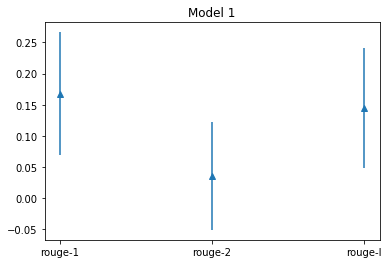

In [23]:
x = [1, 2, 3]
my_xticks = ['rouge-1','rouge-2','rouge-l']
plt.title('Model 1')
plt.xticks(x, my_xticks)
y = [mean1_1, mean2_1, meanl_1]
e = [std1_1, std2_1, stdl_1]
plt.errorbar(x, y, e, linestyle='None', marker='^')

plt.show()

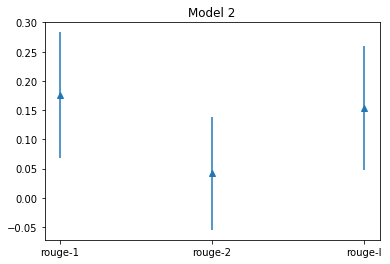

In [24]:
x = [1, 2, 3]
my_xticks = ['rouge-1','rouge-2','rouge-l']
plt.title('Model 2')
plt.xticks(x, my_xticks)
y = [mean1_2, mean2_2, meanl_2]
e = [std1_2, std2_2, stdl_2]
plt.errorbar(x, y, e, linestyle='None', marker='^')

plt.show()

### Testing

After comparing the rouge scores of the model which uses fixed number of clusters of 5 and model 2 which uses elbow method with within sum of squares, it has became clear that model 2 is more successful.

Both models will be tested with the test set as it was specified in the description.

No preprocessing what-so-ever has been done on the test set until testing process.

~1 minute

In [30]:
rouge1_1 = []   # model 1 rouge 1
rouge2_1 = []   # model 1 rouge 2
rougel_1 = []   # model 1 rouge l

rouge1_2 = []   # model 2 rouge 1
rouge2_2 = []   # model 2 rouge 2
rougel_2 = []   # model 2 rouge l

docs_by_vectors_test = sent2vec_by_averaging(test)

######### MODEL 1 - FIXED NUMBER OF CLUSTERS ###########
for doc in docs_by_vectors_test:
    ass, cen = cluster(doc, number_of_clusters=5)   # Cluster with fixed number of clusters 5
    summary = []
    for center in cen:
        summary.append(get_closest_point(center, doc))
    summary_text = ''
    for sentence in summary:
        summary_text += test[docs_by_vectors_test.index(doc)][doc.index(sentence)] + '. '
    score = rouge.get_scores(summary_text, summaries[docs_by_vectors_test.index(doc)])
    rouge1_1.append(score[0]['rouge-1']['f'])
    rouge2_1.append(score[0]['rouge-2']['f'])
    rougel_1.append(score[0]['rouge-l']['f'])

######### MODEL 2 - ELBOW METHOD FOR NUMBER OF CLUSTERS ###########
for doc in docs_by_vectors_test:
    ass, cen = cluster_with_wss(doc)     # Find number of clusters with elbow method
    summary = []
    for center in cen:
        summary.append(get_closest_point(center, doc))
    summary_text = ''
    for sentence in summary:
        summary_text += test[docs_by_vectors_test.index(doc)][doc.index(sentence)] + '. '
    score = rouge.get_scores(summary_text, summaries[docs_by_vectors_test.index(doc)])
    rouge1_2.append(score[0]['rouge-1']['f'])
    rouge2_2.append(score[0]['rouge-2']['f'])
    rougel_2.append(score[0]['rouge-l']['f'])

In [31]:
mean1_1 = sum(rouge1_1) / len(rouge1_1)
std1_1 = np.std(rouge1_1)
mean2_1 = sum(rouge2_1) / len(rouge2_1)
std2_1 = np.std(rouge2_1)
meanl_1 = sum(rougel_1) / len(rougel_1)
stdl_1 = np.std(rougel_1)

mean1_2 = sum(rouge1_2) / len(rouge1_2)
std1_2 = np.std(rouge1_2)
mean2_2 = sum(rouge2_2) / len(rouge2_2)
std2_2 = np.std(rouge2_2)
meanl_2 = sum(rougel_2) / len(rougel_2)
stdl_2 = np.std(rougel_2)

print('MODEL 1')
print('rouge-1 mean: ' + str(mean1_1) + ' ± rouge-1 standard variation: ' + str(std1_1))
print('rouge-2 mean: ' + str(mean2_1) + ' ± rouge-2 standard variation: ' + str(std2_1))
print('rouge-l mean: ' + str(meanl_1) + ' ± rouge-l standard variation: ' + str(stdl_1))
print('MODEL 2')
print('rouge-1 mean: ' + str(mean1_2) + ' ± rouge-1 standard variation: ' + str(std1_2))
print('rouge-2 mean: ' + str(mean2_2) + ' ± rouge-2 standard variation: ' + str(std2_2))
print('rouge-l mean: ' + str(meanl_2) + ' ± rouge-l standard variation: ' + str(stdl_2))

MODEL 1
rouge-1 mean: 0.1409994931003005 ± rouge-1 standard variation: 0.029656488361901948
rouge-2 mean: 0.009336279476938537 ± rouge-2 standard variation: 0.009398243765743651
rouge-l mean: 0.11834131032859002 ± rouge-l standard variation: 0.028189917606710062
MODEL 2
rouge-1 mean: 0.14902688744214443 ± rouge-1 standard variation: 0.029754013152266598
rouge-2 mean: 0.012525434205194613 ± rouge-2 standard variation: 0.009068644038220408
rouge-l mean: 0.12548608714817092 ± rouge-l standard variation: 0.029280024138356443


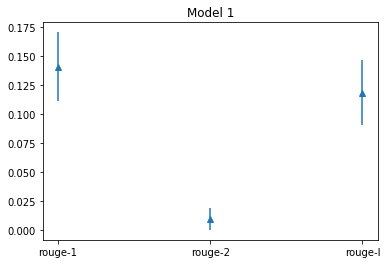

In [32]:
x = [1, 2, 3]
my_xticks = ['rouge-1','rouge-2','rouge-l']
plt.title('Model 1')
plt.xticks(x, my_xticks)
y = [mean1_1, mean2_1, meanl_1]
e = [std1_1, std2_1, stdl_1]
plt.errorbar(x, y, e, linestyle='None', marker='^')

plt.show()

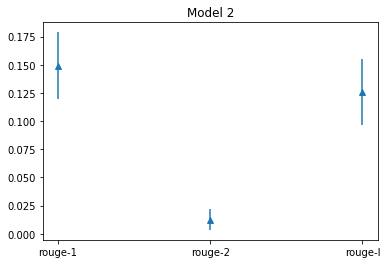

In [33]:
x = [1, 2, 3]
my_xticks = ['rouge-1','rouge-2','rouge-l']
plt.title('Model 2')
plt.xticks(x, my_xticks)
y = [mean1_2, mean2_2, meanl_2]
e = [std1_2, std2_2, stdl_2]
plt.errorbar(x, y, e, linestyle='None', marker='^')

plt.show()

## Conclusions
All the requirements of the project has been accomplished. 

It is clear that elbow method is more successfull for clustering than fixed number of clusters method, as the lenght of the documents vary, as well as their content and their content's variety.

Better rouge scores has been achieved by using tf-idf weighted sentence representation instead of simple average sentence representation and the first intent was to compare models who use tf-idf weighted averaging sentence representation and simple averaging sentence representation. However, the models I had developed with tf-idf weighted sentence representation required preprocessing of the test set and also validation set. In order to create sentence representation of the validation set during the cross validation process for example, tf-idf weights of the validation set should be constructed alongside with training set, which is why I have gave up on that model, as I was not sure whether it would be accepted.

In [26]:
'''scores = [scores1, scores2]
with open('scores.pickle', 'wb') as f:
    vector = pickle.dump(scores, f)'''